# MUSIC RECOMMENDATION SYSTEM

### Recommendation Engine
#### It is too important for online businesses, beyond to understanding and segment the customer, which have almost no physical interaction with their customers. Recommendation engines provide wonderful opportunities to these organizations to not only understand their clientele but also to use that information to increase their revenues. Another important advantage, you can easily integrate a crude recommendation engine in its interaction with the users and then, on the basis of its performance, make the decision to develop a more sophisticated version.

####  Recommendation engines are a way of modeling and rearranging information available about user preferences and then using this information to provide informed recommendations on the basis of that information.

In [1]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass
#ignore annoying warning (from sklearn and seaborn)
warnings.warn = ignore_warn 

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
import math as mt
from scipy.sparse.linalg import * #used for matrix multiplication
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix
from scipy.stats import skew, norm, probplot
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

In [3]:
#Class for Popularity based Recommender System model
class popularity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

        #Get a count of user_ids for each unique song as recommendation score
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)
    
        #Sort the songs based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])
    
        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
        #Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(10)

    #Use the popularity based recommender system model to
    #make recommendations
    def recommend(self, user_id):    
        user_recommendations = self.popularity_recommendations
        
        #Add user_id column for which the recommendations are being generated
        user_recommendations['user_id'] = user_id
    
        #Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols]
        
        return user_recommendations
    

#Class for Item similarity based Recommender System model
class item_similarity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.cooccurence_matrix = None
        self.songs_dict = None
        self.rev_songs_dict = None
        self.item_similarity_recommendations = None
        
    #Get unique items (songs) corresponding to a given user
    def get_user_items(self, user):
        user_data = self.train_data[self.train_data[self.user_id] == user]
        user_items = list(user_data[self.item_id].unique())
        
        return user_items
        
    #Get unique users for a given item (song)
    def get_item_users(self, item):
        item_data = self.train_data[self.train_data[self.item_id] == item]
        item_users = set(item_data[self.user_id].unique())
            
        return item_users
        
    #Get unique items (songs) in the training data
    def get_all_items_train_data(self):
        all_items = list(self.train_data[self.item_id].unique())
            
        return all_items
        
    #Construct cooccurence matrix
    def construct_cooccurence_matrix(self, user_songs, all_songs):
            
        ####################################
        #Get users for all songs in user_songs.
        ####################################
        user_songs_users = []        
        for i in range(0, len(user_songs)):
            user_songs_users.append(self.get_item_users(user_songs[i]))
            
        ###############################################
        #Initialize the item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = np.matrix(np.zeros(shape=(len(user_songs), len(all_songs))), float)
           
        #############################################################
        #Calculate similarity between user songs and all unique songs
        #in the training data
        #############################################################
        for i in range(0,len(all_songs)):
            #Calculate unique listeners (users) of song (item) i
            songs_i_data = self.train_data[self.train_data[self.item_id] == all_songs[i]]
            users_i = set(songs_i_data[self.user_id].unique())
            
            for j in range(0,len(user_songs)):       
                    
                #Get unique listeners (users) of song (item) j
                users_j = user_songs_users[j]
                    
                #Calculate intersection of listeners of songs i and j
                users_intersection = users_i.intersection(users_j)
                
                #Calculate cooccurence_matrix[i,j] as Jaccard Index
                if len(users_intersection) != 0:
                    #Calculate union of listeners of songs i and j
                    users_union = users_i.union(users_j)
                    
                    cooccurence_matrix[j,i] = float(len(users_intersection))/float(len(users_union))
                else:
                    cooccurence_matrix[j,i] = 0
                    
        
        return cooccurence_matrix

    
    #Use the cooccurence matrix to make top recommendations
    def generate_top_recommendations(self, user, cooccurence_matrix, all_songs, user_songs):
        print("Non zero values in cooccurence_matrix :%d" % np.count_nonzero(cooccurence_matrix))
        
        #Calculate a weighted average of the scores in cooccurence matrix for all user songs.
        user_sim_scores = cooccurence_matrix.sum(axis=0)/float(cooccurence_matrix.shape[0])
        user_sim_scores = np.array(user_sim_scores)[0].tolist()
 
        #Sort the indices of user_sim_scores based upon their value
        #Also maintain the corresponding score
        sort_index = sorted(((e,i) for i,e in enumerate(list(user_sim_scores))), reverse=True)
    
        #Create a dataframe from the following
        columns = ['user_id', 'song', 'score', 'rank']
        #index = np.arange(1) # array of numbers for the number of samples
        df = pd.DataFrame(columns=columns)
         
        #Fill the dataframe with top 10 item based recommendations
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in user_songs and rank <= 10:
                df.loc[len(df)]=[user,all_songs[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1
        
        #Handle the case where there are no recommendations
        if df.shape[0] == 0:
            print("The current user has no songs for training the item similarity based recommendation model.")
            return -1
        else:
            return df
 
    #Create the item similarity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

    #Use the item similarity based recommender system model to
    #make recommendations
    def recommend(self, user):
        
        ########################################
        #A. Get all unique songs for this user
        ########################################
        user_songs = self.get_user_items(user)    
            
        print("No. of unique songs for the user: %d" % len(user_songs))
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
                
        return df_recommendations
    
    #Get similar items to given items
    def get_similar_items(self, item_list):
        
        user_songs = item_list
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        user = ""
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
         
        return df_recommendations

In [9]:
# Load the Data Set and MErge it
import pandas as pd
count_play_df = pd.read_csv('kaggle_visible_evaluation_triplets.txt',sep='\t',names=['user','song','play_count'])
track_metadata_df = pd.read_csv('unique_tracks.txt',sep='<SEP>',names = ['title','song_id','artist_name','release'])

In [10]:
first_colum = track_metadata_df.pop('song_id')

In [11]:
track_metadata_df.insert(0,'song_id',first_colum)

In [12]:
track_metadata_df.head()

,song_id,title,artist_name,release
0,SOQMMHC12AB0180CB8,TRMMMYQ128F932D901,Faster Pussy cat,Silent Night
1,SOVFVAK12A8C1350D9,TRMMMKD128F425225D,Karkkiautomaatti,Tanssi vaan
2,SOGTUKN12AB017F4F1,TRMMMRX128F93187D9,Hudson Mohawke,No One Could Ever
3,SOBNYVR12A8C13558C,TRMMMCH128F425532C,Yerba Brava,Si Vos QuerÃ©s
4,SOHSBXH12A8C13B0DF,TRMMMWA128F426B589,Der Mystic,Tangle Of Aspens


In [13]:
third_colum = track_metadata_df.pop('release')

In [14]:
track_metadata_df.insert(2,'release',third_colum)

In [15]:
track_metadata_df.head()

,song_id,title,release,artist_name
0,SOQMMHC12AB0180CB8,TRMMMYQ128F932D901,Silent Night,Faster Pussy cat
1,SOVFVAK12A8C1350D9,TRMMMKD128F425225D,Tanssi vaan,Karkkiautomaatti
2,SOGTUKN12AB017F4F1,TRMMMRX128F93187D9,No One Could Ever,Hudson Mohawke
3,SOBNYVR12A8C13558C,TRMMMCH128F425532C,Si Vos QuerÃ©s,Yerba Brava
4,SOHSBXH12A8C13B0DF,TRMMMWA128F426B589,Tangle Of Aspens,Der Mystic


In [16]:
print('First see of track metadata:')
print('Number of rows:', track_metadata_df.shape[0])
print('Number of unique songs:', len(track_metadata_df.song_id.unique()))
display(track_metadata_df.head())
print('Note the problem with repeated track metadata. Let\'s see of counts play song by users:')
display(count_play_df.shape, count_play_df.head())

First see of track metadata:
Number of rows: 1000000
Number of unique songs: 999056


,song_id,title,release,artist_name
0,SOQMMHC12AB0180CB8,TRMMMYQ128F932D901,Silent Night,Faster Pussy cat
1,SOVFVAK12A8C1350D9,TRMMMKD128F425225D,Tanssi vaan,Karkkiautomaatti
2,SOGTUKN12AB017F4F1,TRMMMRX128F93187D9,No One Could Ever,Hudson Mohawke
3,SOBNYVR12A8C13558C,TRMMMCH128F425532C,Si Vos QuerÃ©s,Yerba Brava
4,SOHSBXH12A8C13B0DF,TRMMMWA128F426B589,Tangle Of Aspens,Der Mystic


Note the problem with repeated track metadata. Let's see of counts play song by users:


(1450933, 3)

,user,song,play_count
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1


#### So, as we expect, before go forward first we need take care of the repeated track data.  we will substitute all inconsistencies by their respective max value by each song Id.

In [17]:
unique_track_metadata_df = track_metadata_df.groupby('song_id').max().reset_index()

print('Number of rows after unique song Id treatment:', unique_track_metadata_df.shape[0])
print('Number of unique songs:', len(unique_track_metadata_df.song_id.unique()))
display(unique_track_metadata_df.head())

Number of rows after unique song Id treatment: 999056
Number of unique songs: 999056


,song_id,title,release,artist_name
0,SOAAABI12A8C13615F,TRBGKMB128F4257851,Afro Jazziac,Herbie Mann
1,SOAAABT12AC46860F0,TRMTUKT12903CEE7C3,Herre Gud Ditt Dyre Namn Og Ã†re,Bergen Big Band
2,SOAAABX12A8C13FEB2,TRODQFM128F42AAD47,N.Y.C. Remix,Guardner
3,SOAAACR12A58A79456,TRDUPEH128F423F4C6,Irresistible,Superchumbo
4,SOAAACY12A58A79663,TROKBXD128F426BA85,Untitled 1,Thuja


### Then we need merge the two datasets based on the songs ids.

In [19]:
user_song_list_count = pd.merge(count_play_df, 
                                unique_track_metadata_df, how='left', 
                                left_on='song', 
                                right_on='song_id')
user_song_list_count.rename(columns={'play_count':'listen_count'},inplace=True)
del(user_song_list_count['song_id'])

## Exploratory Data Analysis (EDA)

In [20]:
display(user_song_list_count.head())
user_song_list_count.listen_count.describe().reset_index().T

,user,song,listen_count,title,release,artist_name
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,You're The One,Dwight Yoakam
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,TRLGMFJ128F4217DBE,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1,TRTNDNE128F1486812,Tive Sim,Cartola
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1,TRASTUE128F930D488,Catch You Baby (Steve Pitron & Max Sanna Radio...,Lonnie Gordon
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1,TRFPLWO128F1486B9E,El Cuatrero,Miguel Calo


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
listen_count,1.45093e+06,3.18715,7.05166,1,1,1,3,923


#### It looks like we have some users obsessed with a single song! A user having heard 923 times a single song is something very extreme considering that we have only 3 times in the third quartile. Let's check how many users listen to a single song more than 3 times and more than 200 times.

In [21]:
print('{:d} users, {:.2%} of total play counts, listening a single more than 200 times'.format(
    count_play_df.user[count_play_df.play_count>200].unique().shape[0],
    count_play_df.play_count[count_play_df.play_count>200].count()/count_play_df.shape[0]))
display(count_play_df.play_count[count_play_df.play_count>200].describe().reset_index().T)

138 users, 0.01% of total play counts, listening a single more than 200 times


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
play_count,154,286.188,102.503,201,221,250,310.25,923


### So, as we can see only 138 users listen to a single song more than 200 times, but, would this be possible?

### Let's consider that a song has 3:30 minutes in average and create it for the two most obsessed users and check out what their songs are:

In [22]:
lunatic = count_play_df.play_count[count_play_df.play_count>count_play_df.play_count.max()-10].values[0]
print('- How much days the most obsessed user can be the fan of a unique song: {:.1f}'.format((lunatic*3.5)/60/24))
display(track_metadata_df[track_metadata_df.song_id.isin(
                  count_play_df[count_play_df.play_count>count_play_df.play_count.max()-10].song.values)])

- How much days the most obsessed user can be the fan of a unique song: 2.2


,song_id,title,release,artist_name
899766,SOXTUWG12AB018A2E2,TRXIHSR12903CC4FA5,Drop The Hammer (Album Version),Kilgore


In [24]:
obsessed = count_play_df.play_count[count_play_df.play_count>count_play_df.play_count.max()-1500].values[1]
print('- How much days the second obsessed user can be the fan of a unique song: {:.1f}'.format((obsessed*3)/60/24))
display(track_metadata_df[track_metadata_df.song_id.isin(count_play_df[count_play_df.play_count==920].song.values)])


- How much days the second obsessed user can be the fan of a unique song: 0.0


,song_id,title,release,artist_name


### So we have to be careful when creating a recommendation system that can be affected by the outliers. Let's take a look at the top 20 in the different features we have:

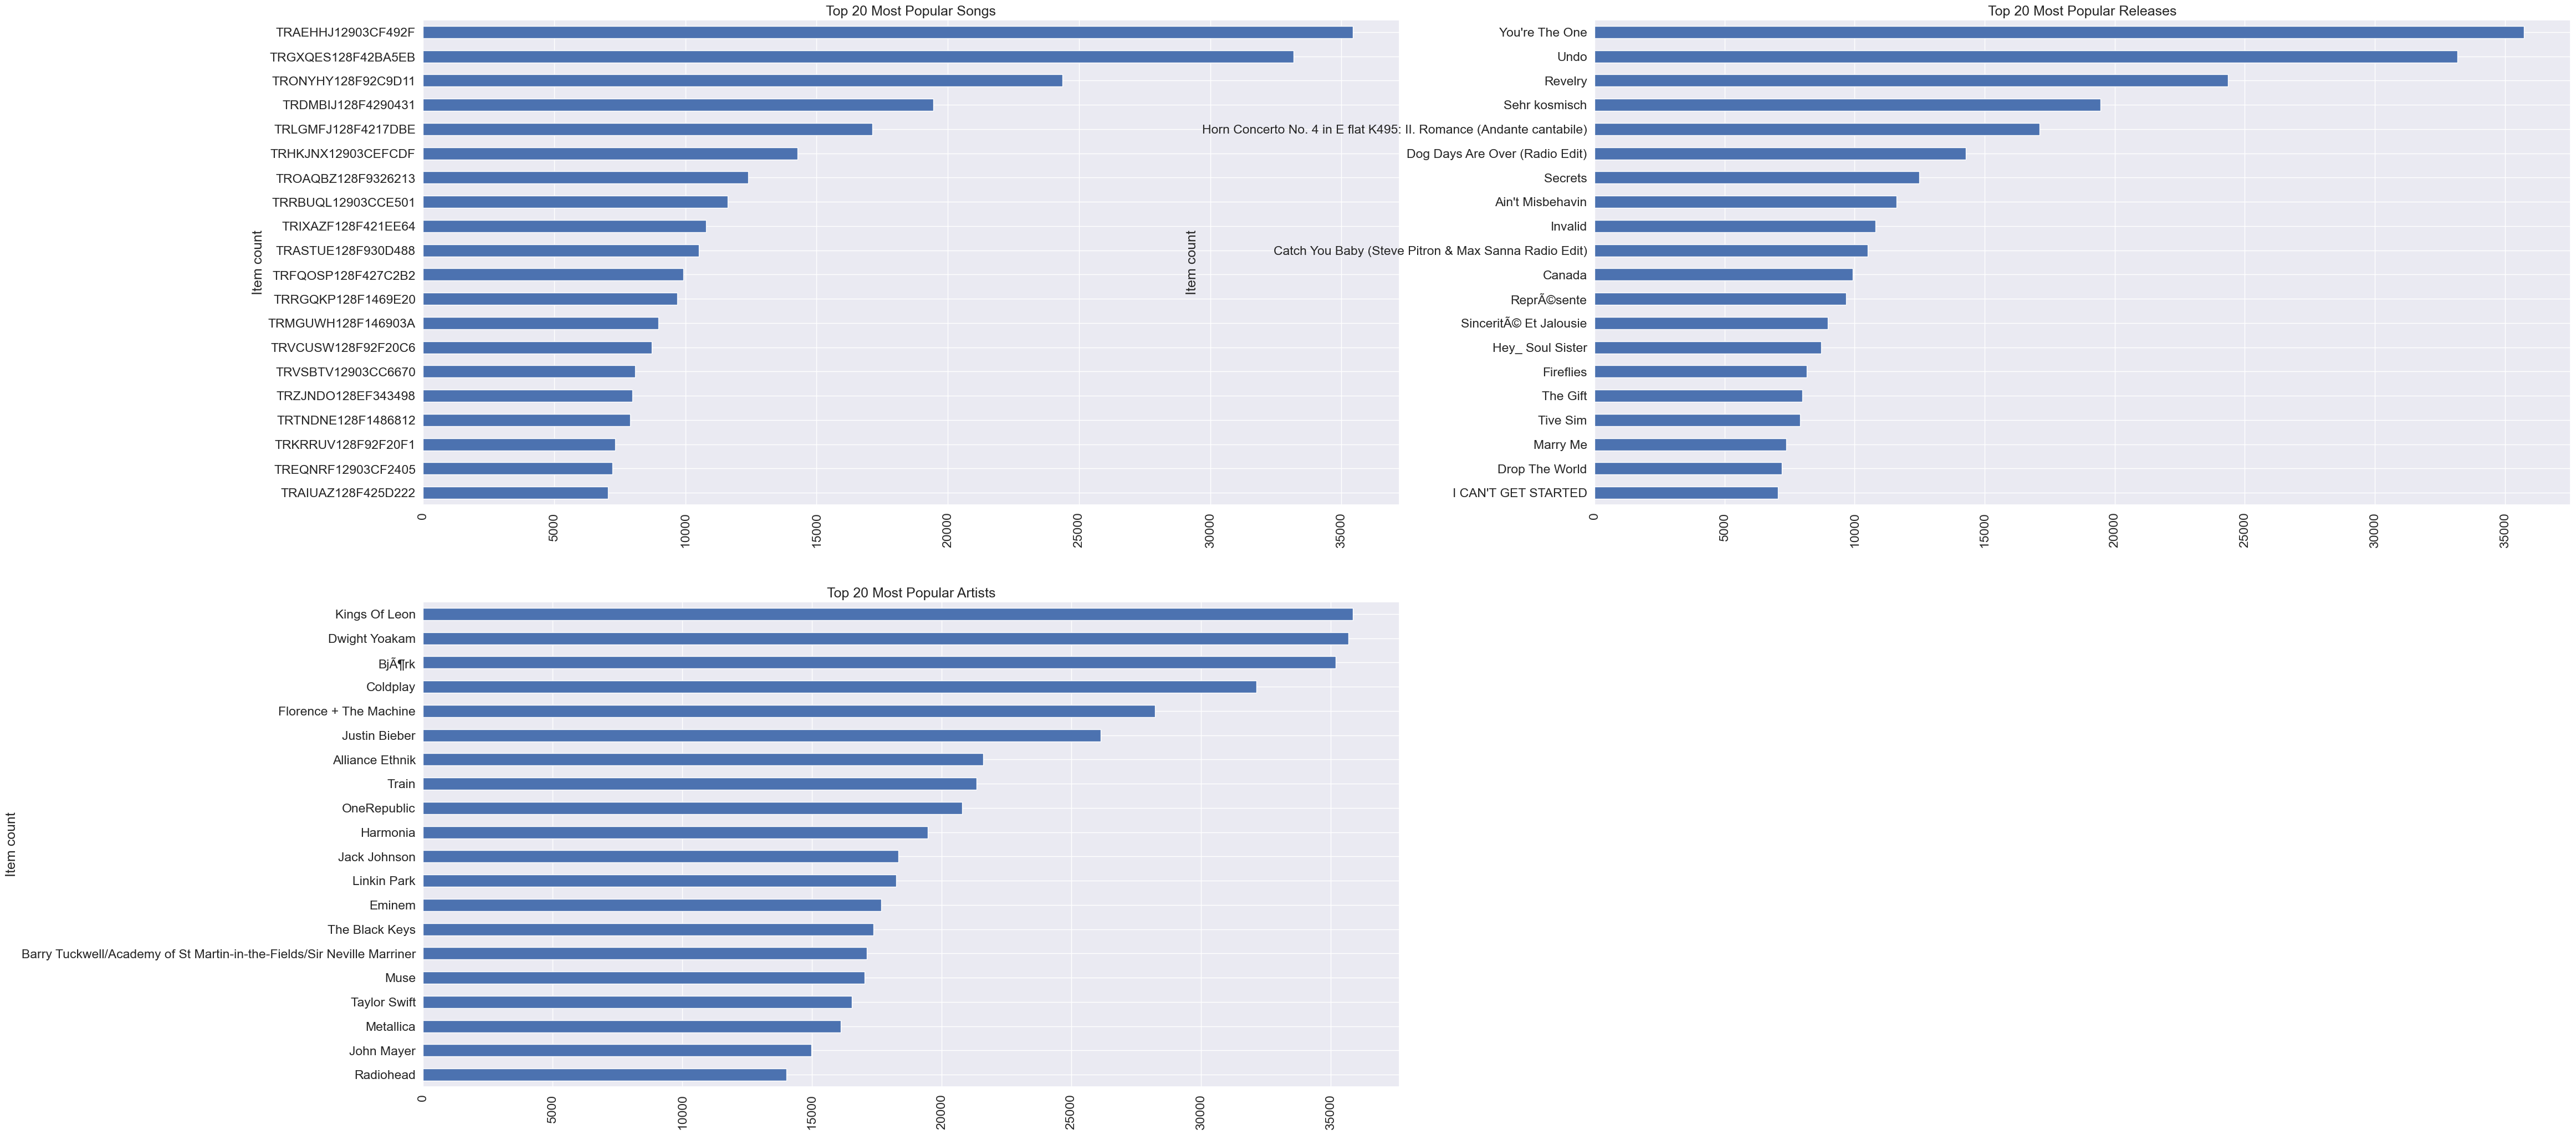

In [26]:
fig = plt.figure(figsize=(50, 25))
a1 = fig.add_subplot(221)
popular_songs = user_song_list_count[['title','listen_count']].groupby('title').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f1 = popular_songs.plot(kind='barh', title='Top 20 Most Popular Songs', legend=False, ax=a1)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

a2 = fig.add_subplot(222)
popular_release = user_song_list_count[['release','listen_count']].groupby('release').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f2 = popular_release.plot(kind='barh', title='Top 20 Most Popular Releases', legend=False, ax=a2)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

a3 = fig.add_subplot(223)
popular_artist = user_song_list_count[['artist_name','listen_count']].groupby('artist_name').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f1 = popular_artist.plot(kind='barh', title='Top 20 Most Popular Artists', legend=False, ax=a3)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

plt.show()

### So the two most obsessed fans did not influence any of the top 20.Let's take a look at the distribution of how many different songs each user listens to, first we create a summary dataset and next a function to help us with better visualization.

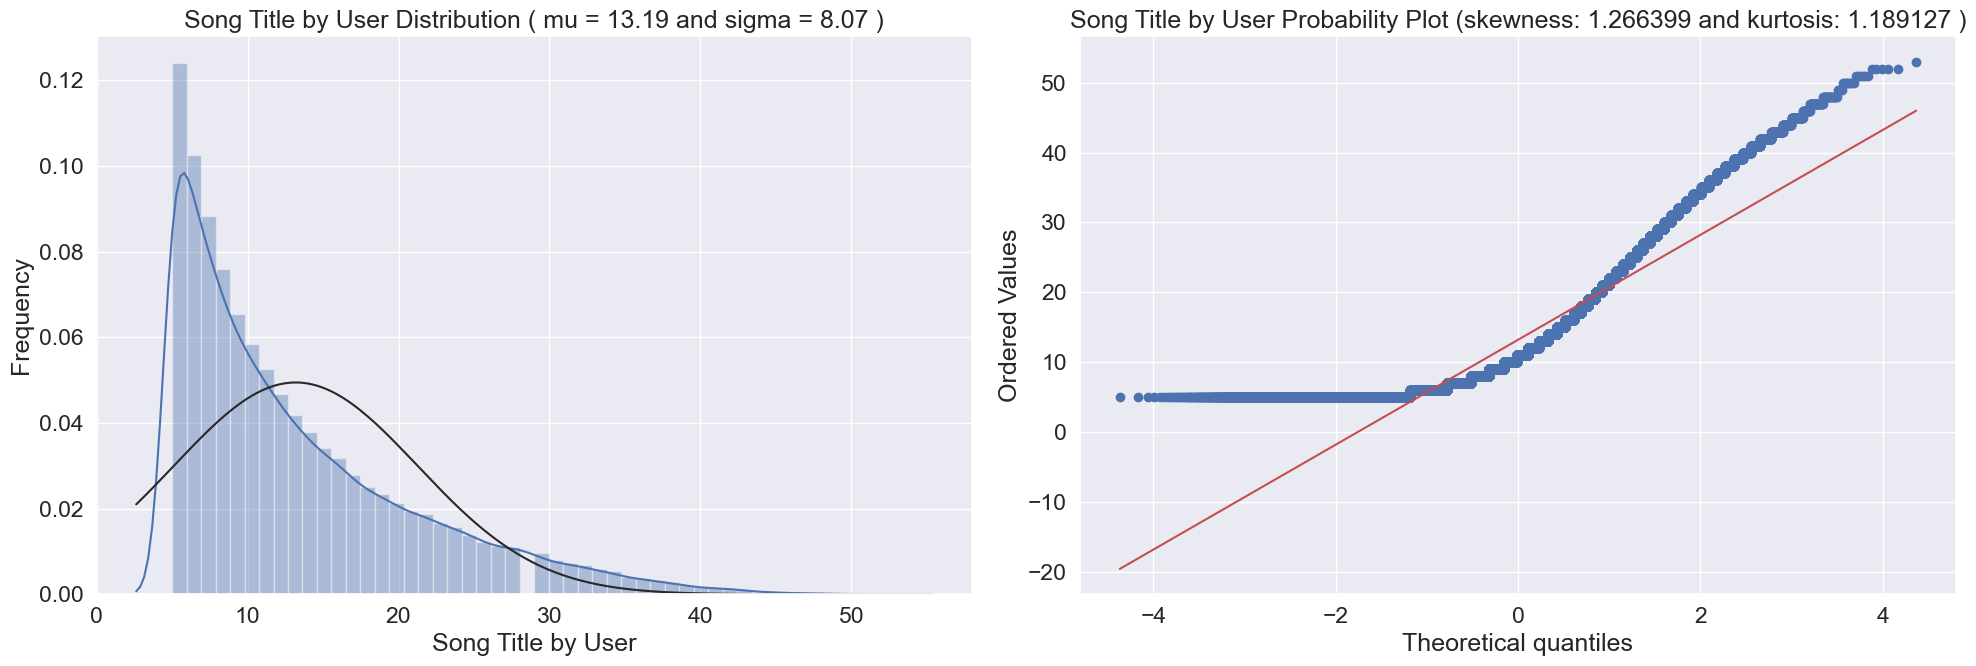

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
title,110000,13.1903,8.07083,5,7,11,17,53


In [27]:
user_song_count_distribution = user_song_list_count[['user','title']].groupby('user').count().\
                                reset_index().sort_values(by='title',ascending = False)

def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

QQ_plot(user_song_count_distribution.title, 'Song Title by User')
user_song_count_distribution.title.describe().reset_index().T


### From the first graph above we can see that song title by user distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased.. As we expect, less than a hundred listen a good number of different songs, but enough to raise the average to above 26.

#### From the Probability Plot, we could see that song title by user also does not align with the diagonal red line which represent normal distribution. The form of its distribution confirm that is a skewed right.

####  With skewness positive of 4.2, we confirm the lack of symmetry and indicate that song title by user are skewed right, as we can see too at the song title by user distribution plot, skewed right means that the right tail is long relative to the left tail, as we expect in counts. The skewness for a normal distribution is zero, and any symmetric data should have a skewness near zero. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

####  Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers, and positive kurtosis indicates a heavy-tailed distribution and negative kurtosis indicates a light tailed distribution. So, with 32.6 of positive kurtosis song title by user are heavy-tailed and definitely has outliers.

####  OK, let's take a look at the distribution of the number of times users heard the most popular song.

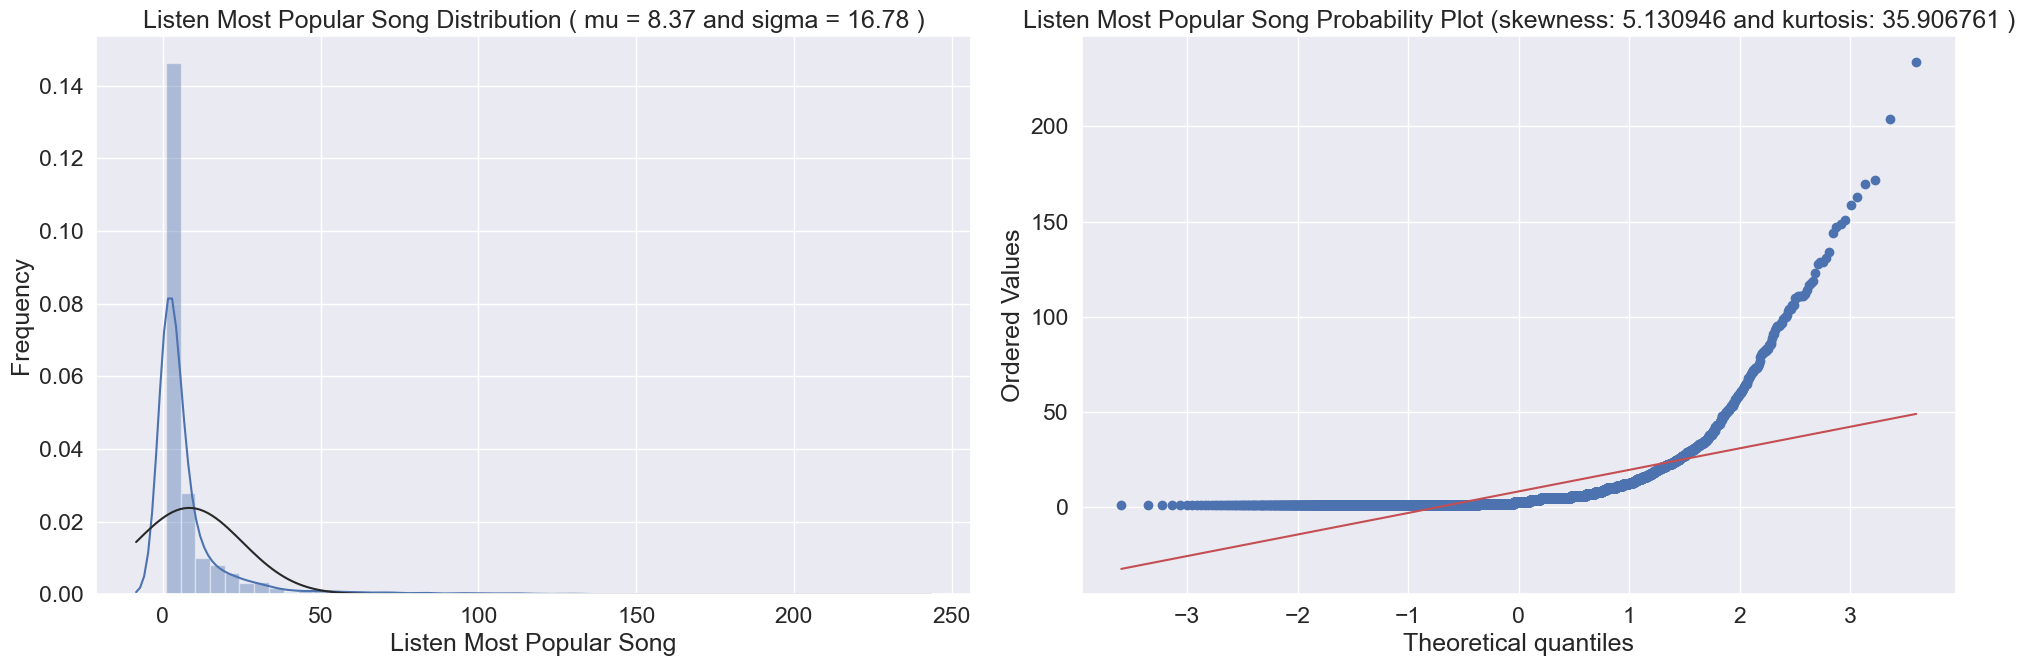

In [29]:
QQ_plot(user_song_list_count[user_song_list_count.release=="You're The One"].listen_count, 'Listen Most Popular Song')


# Recommendation Engine

### The basis of the recommendation engine is always the recorded interaction between the users and products.

### Types of Recommendation Engines
#### The major area of distinction in different recommendation engines comes from the entity that they assume is the most important in the process of generating recommendations.

#### User-based recommendation engines: With the user as the central entity, the algorithm will look for similarities among users and on the basis of those similarities will come up with the recommendation.

#### Content-based recommendation engines: With the content that we are trying to recommend as central entity, the algorithm will attempt to find features about the content and find similar content. Then these similarities will be used to make recommendations to the end users.

#### Hybrid-recommendation engines: Sometimes termed as collaborative filtering recommendation engines, these are one of the most effective classes of recommendation engines, as they take the best features of both classes, users and content of recommendation engines.

## Popularity-Based Recommendation Engine
### The most simplest recommendation engine is the Popularity-Based, that basically standing, if some item is liked by a vast majority of our subscriber base, then it is a good idea to recommend that item to subscribers who have not interacted with that item. The code to develop this kind of recommendation is extremely easy and is effectively just a summarization procedure that determine which items of the content have the most subscriber and then that will become our standard recommendation set for each subscriber.

In [30]:
def create_popularity_recommendation(train_data, user_id, item_id, n=10):
    #Get a count of user_ids for each unique song as recommendation score
    train_data_grouped = train_data.groupby([item_id]).agg({user_id: 'count'}).reset_index()
    train_data_grouped.rename(columns = {user_id: 'score'},inplace=True)
    
    #Sort the songs based upon recommendation score
    train_data_sort = train_data_grouped.sort_values(['score', item_id], ascending = [0,1])
    
    #Generate a recommendation rank based upon score
    train_data_sort['Rank'] = train_data_sort.score.rank(ascending=0, method='first')
        
    #Get the top n recommendations
    popularity_recommendations = train_data_sort.head(n)
    return popularity_recommendations

In [31]:
recommendations = create_popularity_recommendation(user_song_list_count,'user','title', 15)
display(recommendations)

,title,score,Rank
21623,TRDMBIJ128F4290431,5043,1.0
42841,TRGXQES128F42BA5EB,4483,2.0
1042,TRAEHHJ12903CF492F,4136,3.0
45900,TRHKJNX12903CEFCDF,3780,4.0
91120,TRONYHY128F92C9D11,3672,5.0
87814,TROAQBZ128F9326213,3430,6.0
70294,TRLGMFJ128F4217DBE,3272,7.0
132496,TRVCUSW128F92F20C6,2791,8.0
136108,TRVSBTV12903CC6670,2725,9.0
122526,TRTNDNE128F1486812,2668,10.0


### We can use our popularity recommendation function to find the 10 artists recommendations too.

In [32]:
display(create_popularity_recommendation(user_song_list_count,'user','artist_name', 10)) 

,artist_name,score,Rank
5085,Coldplay,12279,1.0
13610,Kings Of Leon,8514,2.0
8801,Florence + The Machine,8213,3.0
12964,Justin Bieber,7669,4.0
11378,Jack Johnson,6784,5.0
26443,Train,6617,6.0
23947,The Black Keys,6507,7.0
7969,Eminem,6297,8.0
18346,OneRepublic,6027,9.0
17317,Muse,5849,10.0


## Item Similarity Based Recommendation Engine
### To provide a more personal recommendation to the user we need apply a recommendation engine that consider some kid of similarities between subscriber and theirs items. In other words, it is a recommendation engine based on calculating similarities between a  subscriber's items and the other items in our dataset. Usually to define similarity among a set of items, we need a feature set on the basis of which both items can be described. In our case it will mean features of the songs on the basis of which one song can be differentiated from another.

### Since our dataset don't have this data, we can use the index to do an implicit similarity, based on common  subscribers, in terms of the users who listen to these songs. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:

 $$ \frac{|A \cup B|}{|A \cap B|} $$

### The basic idea remains that if two songs are being listened to by a large fraction of common subscribers out of the total listeners, the two songs can be said to be similar to each other.

### So, we need calculate the similarity of each song in the subscriber's list to those in our dataset, using the similarity metric defined previously, but we need attention to it can become a computation-intensive step when we have a large number of songs. To make the computation more feasible,probably you use a cluster or, in our case, we limited ours items to the most popular 5,000 songs so it is quite unlikely that we would miss out on any important recommendations.


In [51]:
total_play_count = sum(user_song_list_count.listen_count)
play_count = user_song_list_count[['song', 'listen_count']].groupby('song').sum().\
             sort_values(by='listen_count',ascending=False).head(5000)

print('10000 most popular songs represents {:3.2%} of total listen.'.format(float(play_count.sum())/total_play_count))

song_subset = list(play_count.index[:5000])
user_subset = list(user_song_list_count.loc[user_song_list_count.song.isin(song_subset), 'user'].unique())
user_song_list_count_sub = user_song_list_count[user_song_list_count.song.isin(song_subset)]
display(user_song_list_count_sub.head())

5,000 most popular songs represents 65.98% of total listen.


,user,song,listen_count,title,release,artist_name
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,You're The One,Dwight Yoakam
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,TRLGMFJ128F4217DBE,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1,TRTNDNE128F1486812,Tive Sim,Cartola
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1,TRASTUE128F930D488,Catch You Baby (Steve Pitron & Max Sanna Radio...,Lonnie Gordon
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1,TRFPLWO128F1486B9E,El Cuatrero,Miguel Calo


In [50]:
is_model = item_similarity_recommender_py()
is_model.create(user_song_list_count_sub, 'user', 'title')
user_id = list(user_song_list_count_sub.user)[7]
user_items = is_model.get_user_items(user_id)

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

No. of unique songs for the user: 3
no. of unique songs in the training set: 5000
Non zero values in cooccurence_matrix :1398


,user_id,song,score,rank
0,d7083f5e1d50c264277d624340edaaf3dc16095b,TRLDSHP128F148A8A8,0.015603,1
1,d7083f5e1d50c264277d624340edaaf3dc16095b,TRDNFCG128E0784B0C,0.014486,2
2,d7083f5e1d50c264277d624340edaaf3dc16095b,TRESBHR128F427AF42,0.012066,3
3,d7083f5e1d50c264277d624340edaaf3dc16095b,TROYCGD12903CB5D0E,0.008078,4
4,d7083f5e1d50c264277d624340edaaf3dc16095b,TRHOTRU128E0786380,0.008013,5
5,d7083f5e1d50c264277d624340edaaf3dc16095b,TRQMAJC128F4285821,0.007609,6
6,d7083f5e1d50c264277d624340edaaf3dc16095b,TRDWCBL128F930F41E,0.007121,7
7,d7083f5e1d50c264277d624340edaaf3dc16095b,TRLBBPD128F931B9AC,0.007018,8
8,d7083f5e1d50c264277d624340edaaf3dc16095b,TRZGKFM128F425AE73,0.006667,9
9,d7083f5e1d50c264277d624340edaaf3dc16095b,TROMMAA128EF34318C,0.006561,10


### You do not believe that recommendations are more effective! let's get the top 1 and compare them to the two most played songs by this subscriber.

#### Then, let's see and listen the two song most listen by this user:

In [45]:
display(user_song_list_count_sub[(user_song_list_count_sub.user==user_id) & (user_song_list_count_sub.listen_count)])

,user,song,listen_count,title,release,artist_name
6,d7083f5e1d50c264277d624340edaaf3dc16095b,SOUVUHC12A67020E3B,1,TRCQXMT128E0786397,Lift Me Up,Moby
8,d7083f5e1d50c264277d624340edaaf3dc16095b,SOIPJAX12A8C141A2D,1,TRIKCQI128F92DDC16,Open Your Eyes,Guano Apes
20,d7083f5e1d50c264277d624340edaaf3dc16095b,SONJVYU12A8AE44F9E,1,TRSROOS12903CE26FD,Little L,Jamiroquai


### As you can see, although the algorithms seem to have done a good job of customizing the recommendations, it is clear that we can improve them, so we go to the next recommendation system a bit more complex.

## Matrix factorization based recommendations
### Matrix factorization based recommendation engines) are probably the most used recommendation engines when it comes to implementing recommendation engines in production.

### Matrix factorization are methods that reduce a matrix into constituent parts, such that when these matrices are multiplied we get the original matrix. It make it easier to calculate more complex matrix operations. Matrix factorization methods, also called matrix decompositions methods, are a foundation of linear algebra in computers, even for basic operations such as solving systems of linear equations, calculating the inverse, and calculating the determinant of a matrix.

### Matrix factorization can be used to discover latent features between two different kinds of entities. For example, we can try to explain a song in mathematical terms by measuring its beats, tempo, and other such features and then define similar features in terms of the subscriber. Once we have consciously defined such "features", we can use them to find matches for a subscriber based on some similarity criteria. You can use matrix factorization to discover these latent features and they seem to work great.

### The starting point of any matrix factorization-based method is the utility matrix, a matrix of user Vs item dimension. Not, this is a sparse matrix, since not all item is used by the user. The process of matrix factorization means finding out a low rank approximation of the utility matrix. So we want to break down the utility matrix U into two low rank matrices so that we can recreate the matrix U by multiplying those two matrices:

### Assuming the process helps us identify latent factors/features, meaning as K, our aim is to find two matrices X and Y such that their product (matrix multiplication) approximates R.

X = |U| x K matrix (A matrix with dimensions of num_users * factors)

Y = |P| x K matrix (A matrix with dimensions of factors * num_songs)



### To make a recommendation to the subscriber, we can multiply the corresponding subscriber's row from the first matrix by the item matrix and determine the items from the row with maximum ratings. That will become our recommendations for the subscriber. The first matrix represents the association between the users and the latent features, while the second matrix takes care of the associations between items (songs in our case) and the latent features.

## Matrix Factorization and Singular Value Decomposition (SVD)
There are multiple algorithms available for determining factorization of any matrix. We use one of the simplest algorithms, which is the singular value decomposition or SVD. You can follow these steps to determine the factorization of a matrix using the output of SVD function.

Factorize the matrix to obtain U, S, and V matrices.
Reduce the matrix S to first k components. (The function we are using will only provide k dimensions, so we can skip this step.)
Compute the square root of reduced matrix Sk to obtain the matrix Sk1/2.
Compute the two resultant matrix U*Sk1/2 and Sk1/2*V as these will serve as our two factorized matrices
We can then generate the prediction of user i for product j by taking the dot product of the ith row of the first matrix with the jth column of the second matrix.

Let's create tree functions to help us on it:

compute_svd: It use the svds function provided by the scipy library to break down our utility matrix into three different matrices, and prosed with the others tree steps above.
compute_estimated_matrix: use the decomposed matrices by SVD and provide the predictions.

In [46]:
def compute_svd(urm, K):
    U, s, Vt = svds(urm, K)

    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = mt.sqrt(s[i])

    U = csc_matrix(U, dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)
    
    return U, S, Vt

def compute_estimated_matrix(urm, U, S, Vt, uTest, K, test):
    rightTerm = S*Vt 
    max_recommendation = 250
    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    recomendRatings = np.zeros(shape=(MAX_UID,max_recommendation ), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        estimatedRatings[userTest, :] = prod.todense()
        recomendRatings[userTest, :] = (-estimatedRatings[userTest, :]).argsort()[:max_recommendation]
    return recomendRatings

def show_recomendations(uTest, num_recomendations = 10):
    for user in uTest:
        print('-'*70)
        print("Recommendation for user id {}".format(user))
        rank_value = 1
        i = 0
        while (rank_value <  num_recomendations + 1):
            so = uTest_recommended_items[user,i:i+1][0]
            if (small_set.user[(small_set.so_index_value == so) & (small_set.us_index_value == user)].count()==0):
                song_details = small_set[(small_set.so_index_value == so)].\
                    drop_duplicates('so_index_value')[['title','artist_name']]
                print("The number {} recommended song is {} BY {}".format(rank_value, 
                                                                      list(song_details['title'])[0],
                                                                      list(song_details['artist_name'])[0]))
                rank_value+=1
            i += 1

#### The first thing that we notice is that we have no concept of "rating" in our data. All we have are the play counts of various songs. This is a well known problem in the case of recommendation engines and is called the "implicit feedback" problem. There are many ways to solve this problem but we will look at a very simple and intuitive solution. We will replace the play count with a fractional play count. The logic being that this will measure the strength of "likeness" for a song in the range of [0,1].

In [52]:
user_song_list_listen = user_song_list_count[['song','listen_count']].groupby('song').sum().reset_index()
user_song_list_listen.rename(columns={'listen_count':'total_listen_count'},inplace=True)
user_song_list_count_merged = pd.merge(user_song_list_count,user_song_list_listen)
user_song_list_count_merged['fractional_play_count'] = \
    user_song_list_count_merged['listen_count']/user_song_list_count_merged['total_listen_count']

display(user_song_list_count_merged[user_song_list_count_merged.user =='d7083f5e1d50c264277d624340edaaf3dc16095b']\
        [['user','song','listen_count','fractional_play_count']].head())


,user,song,listen_count,fractional_play_count
13180,d7083f5e1d50c264277d624340edaaf3dc16095b,SOUVUHC12A67020E3B,1,0.001425
13315,d7083f5e1d50c264277d624340edaaf3dc16095b,SOUQERE12A58A75633,1,0.125000
13323,d7083f5e1d50c264277d624340edaaf3dc16095b,SOIPJAX12A8C141A2D,1,0.003058
13371,d7083f5e1d50c264277d624340edaaf3dc16095b,SOEFCDJ12AB0185FA0,2,1.000000
13372,d7083f5e1d50c264277d624340edaaf3dc16095b,SOATCSU12A8C13393A,1,0.027778


### The next transformation of data that is required is to convert our dataframe into a numpy matrix in the format of utility matrix. We will convert our dataframe into a sparse matrix, sparse matrices are suitable for representation of such a matrix. Since we won't be able to transform our song IDs and user IDs into a numpy matrix, we will convert these indices into numerical indices. Then we will use these transformed indices to create our sparse numpy matrix.

In [58]:
user_codes = user_song_list_count_merged.user.drop_duplicates().reset_index()
user_codes.rename(columns={'index':'user_index'}, inplace=True)
user_codes['us_index_value'] = list(user_codes.index)

song_codes = user_song_list_count_merged.song.drop_duplicates().reset_index()
song_codes.rename(columns={'index':'song_index'}, inplace=True)
song_codes['so_index_value'] = list(song_codes.index)

small_set = pd.merge(user_song_list_count_merged,song_codes,how='left')
small_set = pd.merge(small_set,user_codes,how='left')
mat_candidate = small_set[['us_index_value','so_index_value','fractional_play_count']]

data_array = mat_candidate.fractional_play_count.values
row_array = mat_candidate.us_index_value.values
col_array = mat_candidate.so_index_value.values

data_sparse = coo_matrix((data_array, (row_array, col_array)),dtype=float)

display(data_sparse)

print('Subscriber used to performed the item similarity based recommendations:.')
display(user_codes[user_codes.user =='fd50c4007b68a3737fe052d5a4f78ce8aa117f3d'])


<110000x163206 sparse matrix of type '<class 'numpy.float64'>'
	with 1450933 stored elements in COOrdinate format>

Subscriber used to performed the item similarity based recommendations:.


,user_index,user,us_index_value
0,0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,0


### Once we have converted our matrix into a sparse matrix, we specify 50 as the number of latent factors we want to factorize our data and call ours functions first to compute the SVD, followed by the compute estimated matrix for the users ids sets by uTest variable:

In [60]:
K=50
urm = data_sparse
MAX_PID = urm.shape[1]
MAX_UID = urm.shape[0]

U, S, Vt = compute_svd(urm, K)
uTest = [4,5,6,7,8,83,23]

uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)

show_recomendations(uTest)

MemoryError: Unable to allocate 84.8 MiB for an array with shape (110000, 101) and data type float64

## Expected OUTPUT (for u shriharsha)
----------------------------------------------------------------------
Recommendation for user id 4
The number 1 recommended song is 911 BY Wyclef Jean / Mary J. Blige
The number 2 recommended song is If I Ain't Got You BY Alicia Keys
The number 3 recommended song is Sample Track 2 BY Simon Harris
The number 4 recommended song is Kennedy Rag BY Suzy Thompson
The number 5 recommended song is Clocks BY Coldplay
The number 6 recommended song is Yellow BY Coldplay
The number 7 recommended song is Hey_ Soul Sister BY Train
The number 8 recommended song is The Scientist BY Coldplay
The number 9 recommended song is Eco BY Jorge Drexler
The number 10 recommended song is Kryptonite BY 3 Doors Down
----------------------------------------------------------------------
Recommendation for user id 5
The number 1 recommended song is Eenie Meenie BY Sean Kingston and Justin Bieber
The number 2 recommended song is Sample Track 2 BY Simon Harris
The number 3 recommended song is U Smile BY Justin Bieber
The number 4 recommended song is Love Me BY Justin Bieber
The number 5 recommended song is One Time BY Justin Bieber
The number 6 recommended song is That Should Be Me BY Justin Bieber
The number 7 recommended song is Teach Me How To Dougie BY California Swag District
The number 8 recommended song is The Gift BY Angels and Airwaves
The number 9 recommended song is Kennedy Rag BY Suzy Thompson
The number 10 recommended song is One Less Lonely Girl BY Justin Bieber
--------

### Let's see the ID 0, he/she is the same one for whom we performed the item similarity based recommendations earlier. Note how the recommendations have changed from the previous two systems.

In [61]:
uTest = [0]
#Get estimated rating for test user
print("Predictied ratings:")
uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)
show_recomendations(uTest)

Predictied ratings:


ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

## Excepted Output (for u sriharsha)
Predictied ratings:
----------------------------------------------------------------------
Recommendation for user id 0
The number 1 recommended song is Basic Space BY The xx
The number 2 recommended song is Infinity BY The xx
The number 3 recommended song is I Wanna Be Sedated (Remastered Album Version ) BY Ramones
The number 4 recommended song is Fantasy BY The xx
The number 5 recommended song is The Big Gundown BY The Prodigy
The number 6 recommended song is CIEÑ BY Milczenie Owiec
The number 7 recommended song is Home BY Edward Sharpe & The Magnetic Zeros
The number 8 recommended song is Cosmic Love BY Florence + The Machine
The number 9 recommended song is Speak BY Godsmack
The number 10 recommended song is You've Got The Love BY Florence + The Machine

## Conclusion
#### The task to building a recommendation engine is to hard, and we didn't use any library to can have better understanding of what goes on behind a recommendation engine. Once we have defined the focus entity, our greatest effort will be to prepare the data according to this entity and to meet the recommended recommendation algorithm.

#### The choice of the algorithm also passes through the information we have, but as we have seen, even with few characteristics, we can develop systems of recommendations of diverse complexity and with expressive results for the business.

### Trying to implement KNN